<a href="https://colab.research.google.com/github/RSN601KRI/CreateOwnImageClassifier/blob/main/CreateImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.4.1+cu121
False


In [3]:
# Imports here

%matplotlib inline
%config InlineBackend.figure.format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import time
import json
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

from tqdm import tqdm

import os

In [4]:
!pip install torchvision

In [5]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-10-01 13:35:26--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.196.208, 52.216.48.224, 52.217.168.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.196.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  38.0MB/s    in 9.2s    

2024-10-01 13:35:36 (35.7 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': No such file or directory


In [6]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [8]:
import json
import collections

# Read the JSON file containing category names
with open('cat_to_name.json', 'r') as file:
    categories = json.load(file)

# Convert keys to integers and create a new dictionary
categories_int_keyed = {int(key): value for key, value in categories.items()}

# Sort the dictionary by keys and create an ordered dictionary
sorted_categories = collections.OrderedDict(sorted(categories_int_keyed.items()))

In [9]:
model = models.vgg16(pretrained = True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad=False

model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(512, 102),
                                nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
epochs = 5
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}")

    for inputs, labels in train_loader_tqdm:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss / len(train_loader))

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    valid_loader_tqdm = tqdm(valid_loader, total=len(valid_loader), desc="Validating")

    with torch.no_grad():
        for inputs, labels in valid_loader_tqdm:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            valid_loader_tqdm.set_postfix(loss=running_loss / len(valid_loader))

    valid_loss = running_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{epochs}], '
        f'Train Loss: {train_loss:.4f}, '
        f'Valid Loss: {valid_loss:.4f}, '
        f'Accuracy: {accuracy:.2f}%')

Validating: 100%|██████████| 13/13 [08:14<00:00, 38.06s/it, loss=0.734]


Epoch [1/5], Train Loss: 2.2588, Valid Loss: 0.7342, Accuracy: 82.03%


Validating: 100%|██████████| 13/13 [08:22<00:00, 38.62s/it, loss=0.546]


Epoch [2/5], Train Loss: 1.0733, Valid Loss: 0.5464, Accuracy: 85.94%


Validating: 100%|██████████| 13/13 [08:16<00:00, 38.17s/it, loss=0.42]


Epoch [3/5], Train Loss: 0.8275, Valid Loss: 0.4198, Accuracy: 87.78%


Validating: 100%|██████████| 13/13 [08:18<00:00, 38.36s/it, loss=0.371]


Epoch [4/5], Train Loss: 0.7253, Valid Loss: 0.3709, Accuracy: 89.85%


Validating: 100%|██████████| 13/13 [08:22<00:00, 38.68s/it, loss=0.384]

Epoch [5/5], Train Loss: 0.6625, Valid Loss: 0.3837, Accuracy: 89.12%


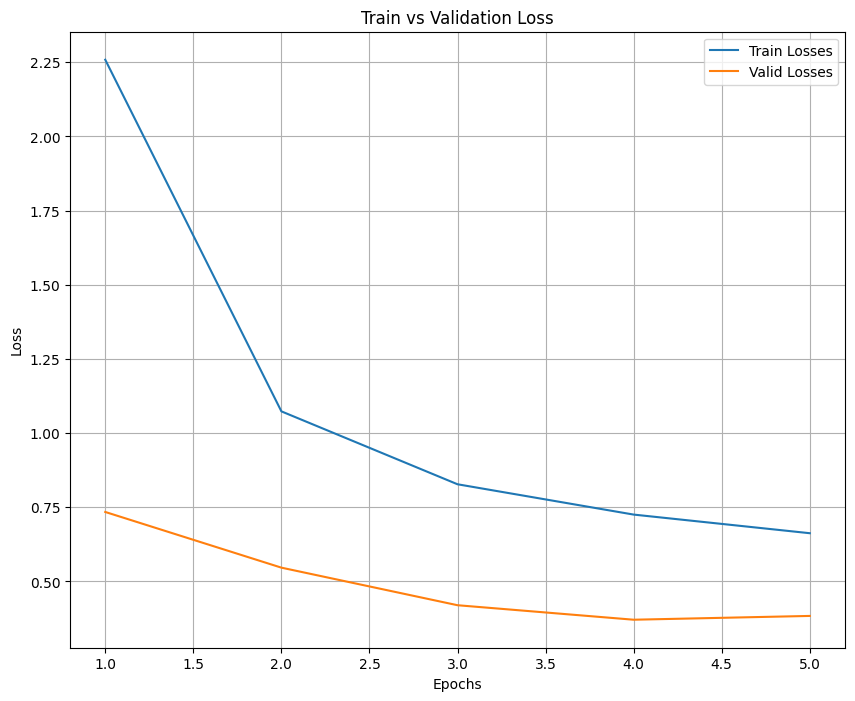

In [12]:
 epochs = range(1, len(train_losses)+1)

plt.figure(figsize = (10,8))
plt.plot(epochs, train_losses, label = 'Train Losses')
plt.plot(epochs, valid_losses, label = 'Valid Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()

test_loss = 0.0
correct = 0
total = 0


with torch.no_grad():
    for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)

        loss = criterion(preds, labels)

        test_loss+=loss.item()

        _, predicted = preds.max(1)

        total+=labels.size(0)

        correct += (predicted == labels).sum().item()


test_loss /= len(test_loader)
test_accuracy = 100*correct/total

print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.446, Test Accuracy: 87.67%


In [16]:
# TODO: Save the checkpoint
model.class_to_idx = train_data.class_to_idx

checkpoint = {
    'architecture': 'vgg16',
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': train_data.class_to_idx,
    'classifier': model.classifier,
    'epochs': epochs, # Use the existing 'epochs' variable instead of the undefined 'num_epochs'
    'learning_rate': 0.001
}

torch.save(checkpoint, 'my_vgg_checkpoint.pth')

In [18]:
checkpoint = torch.load('my_vgg_checkpoint.pth')

model = models.vgg16(pretrained=True) # Corrected the typo 'pretained' to 'pretrained'
model.classifier = checkpoint['classifier']
model.load_state_dict(checkpoint['model_state_dict'])
model.class_to_idx = checkpoint['class_to_idx']
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = checkpoint['epochs']

print(model)
print(optimizer)
print(epochs)

<ipython-input-18-e03f2cf3cf18>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('my_vgg_checkpoint.pth')
/usr/local/lib/python3.10/dist-packages/tor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model

    pil_img = Image.open(image)

    edit_img = transforms.Compose([transforms.Resize(226),
                                  transforms.RandomCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224,0.225])])

    img_tensor = edit_img(pil_img)

    processed = np.array(img_tensor)

    processed = processed.transpose((0,2,1))

    return processed

image_path = test_dir+'/1/image_06743.jpg'
img = process_image(image_path)
print(img.shape)

(3, 224, 224)


<Axes: >

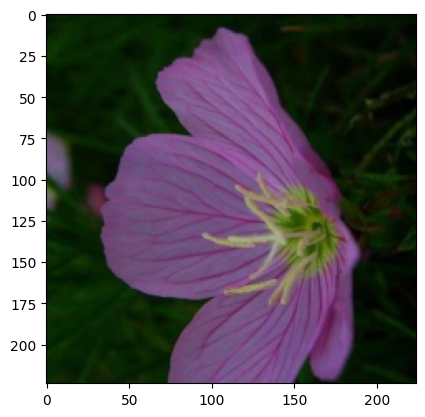

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        ax.set_title(title)

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Reshape mean and std to match the image dimensions
    mean = mean.reshape(1, 1, 3)
    std = std.reshape(1, 1, 3)

    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

imshow(process_image(test_dir+"/1/image_06752.jpg"))

In [21]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    model.to(device)

    img_tensor = torch.tensor(process_image(image_path))

    img_tensor = img_tensor.to(device)

    img_tensor = img_tensor.unsqueeze(0)

    model.eval()

    with torch.no_grad():
        preds = model(img_tensor)

        probs = F.softmax(preds, dim=1)

        top_p, top_class = probs.topk(topk, dim=1)

    top_p = top_p.squeeze().tolist()
    top_class = top_class.squeeze().tolist()

    top_class = [i+1 for i in top_class ]

    return top_p, top_class


In [22]:
probs, classes = predict(test_dir+"/1/image_06752.jpg", model)
print(probs)
print(classes)

[0.6894171237945557, 0.2579747438430786, 0.014959814958274364, 0.005098257679492235, 0.004946540109813213]
[1, 14, 51, 101, 13]


In [24]:
# Make sure the 'cat_to_name.json' file is in the same directory as your notebook
# If not, adjust the file path accordingly
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

pred_class = ""
max_val = -1

for prob, clas in zip(probs, classes):
    if prob>max_val:
        max_val = prob
        pred_class = clas

print(f"Class Predicter:", cat_to_name.get(str(pred_class), "Unknown")) # Convert pred_class to string for key lookup
print(probs)

Class Predicter: pink primrose
[0.6894171237945557, 0.2579747438430786, 0.014959814958274364, 0.005098257679492235, 0.004946540109813213]


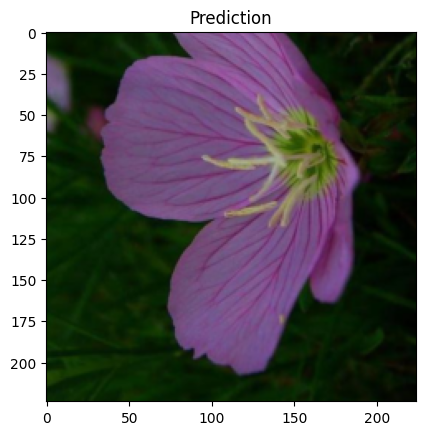

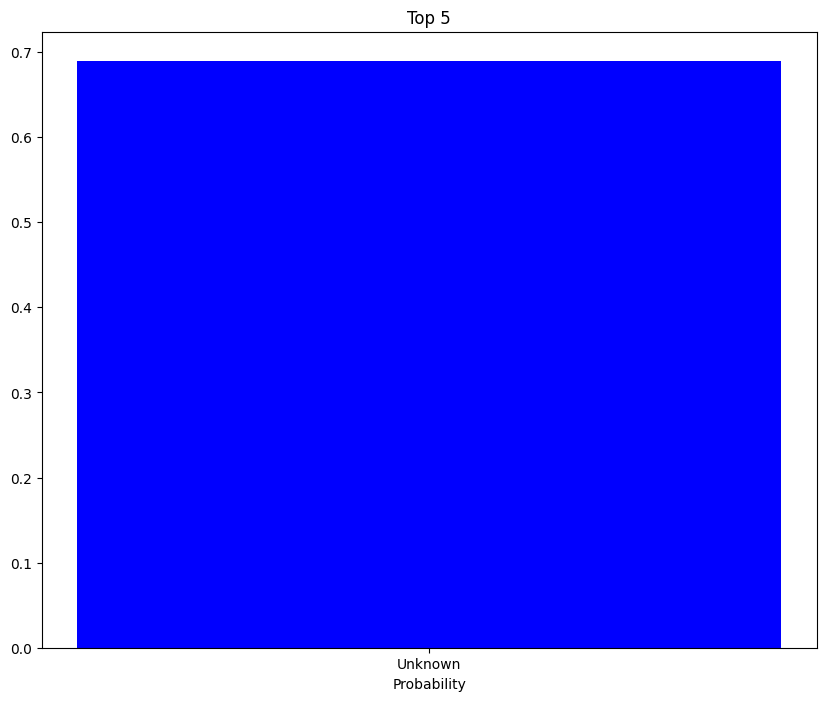

In [25]:
imshow(torch.tensor(process_image(test_dir+"/1/image_06752.jpg")), title = "Prediction")
class_names = [cat_to_name.get(clas, "Unknown") for clas in classes]

plt.figure(figsize=(10,8))
plt.bar(class_names, probs, color= 'blue')
plt.xlabel("Probability")
plt.title("Top 5")
plt.show()

In [26]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth

rm: cannot remove 'checkpoint.pth': No such file or directory
